# Source detection with Gammapy

## Introduction

This notebook show how to do source detection with Gammapy using one of the methods available in [gammapy.detect](http://docs.gammapy.org/dev/detect/index.html).

We will do this:

* produce 2-dimensional test-statistics (TS) images using Fermi-LAT 2FHL high-energy Galactic plane survey dataset
* run a peak finder to make a source catalog
* do some simple measurements on each source
* compare to the 2FHL catalog

Note that what we do here is a quick-look analysis, the production of real source catalogs use more elaborate procedures.

We will work with the following functions and classes:

* [gammapy.maps.WcsNDMap](http://docs.gammapy.org/dev/api/gammapy.maps.WcsNDMap.html)
* [gammapy.detect.TSMapEstimator](http://docs.gammapy.org/dev/api/gammapy.detect.TSMapEstimator.html)
* [gammapy.detect.find_peaks](http://docs.gammapy.org/dev/api/gammapy.detect.find_peaks.html)

## Setup

As always, let's get started with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.coordinates import SkyCoord
from gammapy.maps import Map
from gammapy.detect import TSMapEstimator, find_peaks
from gammapy.catalog import source_catalogs

## Compute TS image

In [3]:
# Load data from files
filename = '../datasets/fermi_survey/all.fits.gz'
opts = {'position': SkyCoord(0, 0, unit='deg', frame='galactic'), 'width': (20, 8)}
maps = {
    'counts': Map.read(filename, hdu='COUNTS').cutout(**opts),
    'background': Map.read(filename, hdu='BACKGROUND').cutout(**opts),
    'exposure': Map.read(filename, hdu='EXPOSURE').cutout(**opts),
}

In [4]:
%%time 
# Compute a source kernel (source template) in oversample mode,
# PSF is not taken into account
kernel = Gaussian2DKernel(2.5, mode='oversample')
estimator = TSMapEstimator()
images = estimator.run(maps, kernel)

CPU times: user 542 ms, sys: 61.1 ms, total: 603 ms
Wall time: 2.04 s


## Plot images

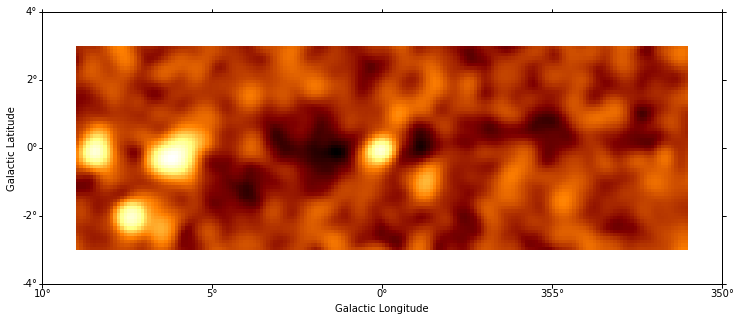

In [5]:
plt.figure(figsize=(15, 5))
images['sqrt_ts'].plot();

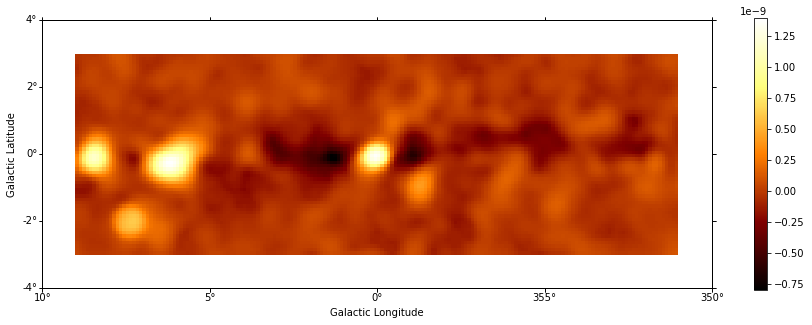

In [6]:
plt.figure(figsize=(15, 5))
images['flux'].plot(add_cbar=True);

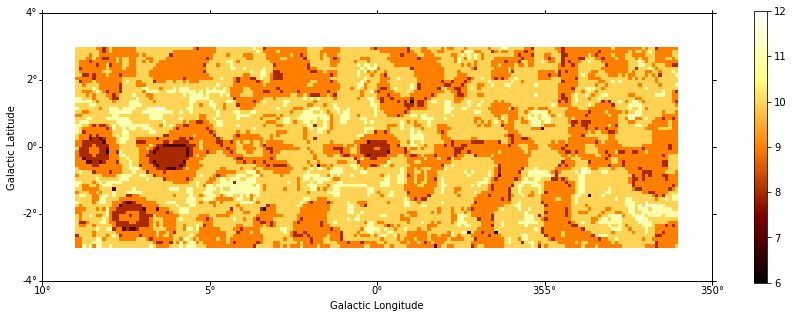

In [7]:
plt.figure(figsize=(15, 5))
images['niter'].plot(add_cbar=True);

## Source catalog

Let's run a peak finder on the `sqrt_ts` image to get a list of sources (positions and peak `sqrt_ts` values).

In [8]:
sources = find_peaks(images['sqrt_ts'], threshold=8)
sources

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
11.386,38,37,270.13528,-23.76653
10.044,15,38,271.27051,-21.71617
10.008,99,39,266.48351,-28.91953
9.7378,26,19,272.49049,-23.60089


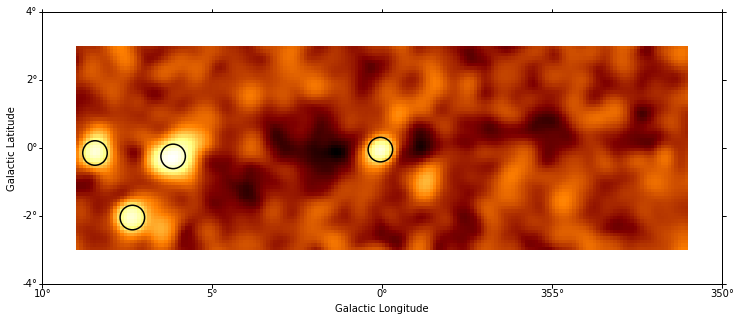

In [9]:
# Plot sources on top of significance sky image
plt.figure(figsize=(15, 5))

images['sqrt_ts'].plot()

plt.gca().scatter(
    sources['ra'], sources['dec'],
    transform=plt.gca().get_transform('icrs'),
    color='none', edgecolor='black', marker='o', s=600, lw=1.5,
);

## Measurements

* TODO: show cutout for a few sources and some aperture photometry measurements (e.g. energy distribution, significance, flux)

In [10]:
# TODO

## Compare to 2FHL

TODO

In [11]:
fermi_2fhl = source_catalogs['2fhl']
fermi_2fhl.table[:5][['Source_Name', 'GLON', 'GLAT']]

Source_Name,GLON,GLAT
,deg,deg
bytes18,float32,float32
2FHL J0008.1+4709,115.339355,-15.068757
2FHL J0009.3+5031,116.12411,-11.793202
2FHL J0018.5+2947,114.46349,-32.54235
2FHL J0022.0+0006,107.171715,-61.86175
2FHL J0033.6-1921,94.28002,-81.22237


## Exercises

TODO: put one or more exercises

In [12]:
# Start exercises here!

## What next?

In this notebook, we have seen how to work with images and compute TS images from counts data, if a background estimate is already available.

Here's some suggestions what to do next:

- TODO: point to background estimation examples
- TODO: point to other docs ...